# Data exploration and basic ConvNN for Image classification

*University of Waterloo Geospatial Club - Winter 2019*

## [Slides](http://bit.ly/geoml-1) and [Kernel](https://www.kaggle.com/jrmistry/uwgeo-club-ml-for-vector-geodata-workshop-1) for the first workshop on Machine Learning for [Vector data](https://www.kaggle.com/jrmistry/killed-or-seriously-injured-ksi-toronto-clean).

The purpose of the workshop is to give the [UWaterloo](https://uwaterloo.ca/) students and the members of the [Geospatial Club](http://bit.ly/uwgeospatial) an introduction to the most recent Machine Learning tools for analysis of Geospatial data. The workshop is held in collaboration with the [Geospatial Centre at the University of Waterloo](https://uwaterloo.ca/library/geospatial/).

We hope that you will learn something new from the content of this workshop. If you have questions after the workshop, then please feel free to message the Geospatial Club or the workshop presenters.

* [Jaydeep Mistry](https://www.linkedin.com/in/jaydeep-mistry/) at jaydeep.mistry@uwaterloo.ca

* [Juan Carrillo](https://www.linkedin.com/in/jmcarrillog/) at jmcarril@uwaterloo.ca



| *References* |
------------ |
[[1]](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)  | Planet: Understanding the Amazon from Space. Featured Kaggle Competition.
[[2]](https://www.kaggle.com/philschmidt/multilabel-classification-rainforest-eda) | Kernel by Philipp Schmidt
[[3]](https://www.kaggle.com/ekami66/0-92837-on-private-lb-solution-with-keras) | Kernel by Tuatini Godard
[[4]](https://www.kaggle.com/anokas/simple-keras-starter?fbclid=IwAR0ohl2rTL4jajyvL26SDKN8s4ZuZRSU2ir4KShM0Cw1-XRBH5DJ_6zTIpU) | Source code by Mikel Bober
[[5]](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/) | Source code by Jason Brownlee
[[6]](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/) | Normalized Difference Vegetation Index (NDVI)
[[7]](https://lvdmaaten.github.io/tsne/) | t-Distributed Stochastic Neighbor Embedding (t-SNE)
[[8]](https://matplotlib.org/) | Matplotlib documentation
[[9]](https://tqdm.github.io/) | tqdm documentation
[[10]](https://docs.scipy.org/doc/) | Scipy documentation

## Dataset: Satellite data from the Amazon rainforest

Square tiles (256x256pix.) of high-resolution, four band (RGB + IR) images from Planet Flock 2 Satellites. Each tile can have multiple (common and less common) labels, but only one of the cloud cover labels.

Common labels | Less Common Labels | Cloud Cover Labels
------------ | ------------- | -------------
Primary Rain Forest | Slash and Burn | Clear
Water (Rivers & Lakes) | Selective Logging | Partly cloudy
Habitation | Blooming | Cloudy
Agriculture | Conventional Mining | Haze
Road | Artisinal Mining |
Cultivation | Blow Down |
Bare Ground | |

More details about the dataset [here](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data)

## Import required libraries

In [1]:
# Import required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns
import cv2
from glob import glob # handles pathnames 
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from skimage import io
import tifffile

import os
import gc
import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import cv2
from tqdm import tqdm
from sklearn.metrics import fbeta_score

Using TensorFlow backend.


In [2]:
# Print filenames of input datasets
print(check_output(["ls", "../input"]).decode("utf8"))

sample_submission_v2.csv
test-jpg-v2
test-tif-v3
test_v2_file_mapping.csv
train-jpg
train-tif-v2
train_v2.csv



## Preview some images
More than 40.000 images in the training set.

In [3]:
labels_df = pd.read_csv('../input/train_v2.csv')

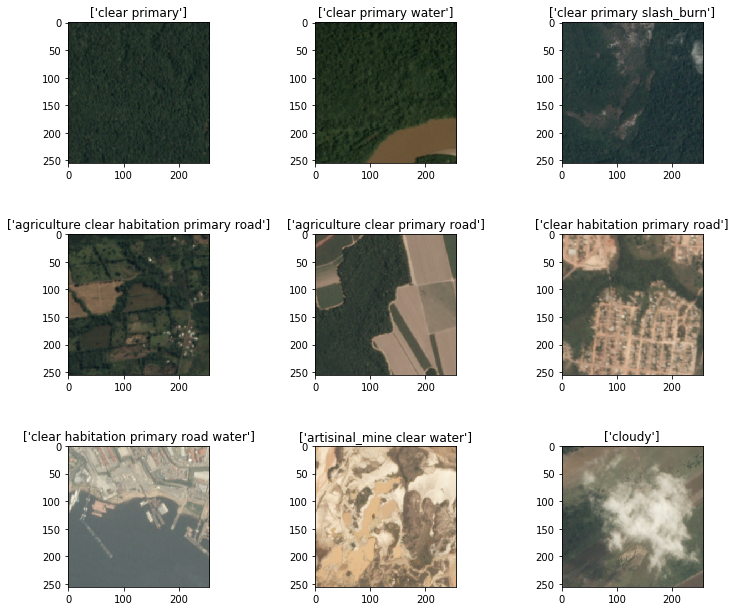

In [4]:
# Pick nine images (jpg)
all_image_paths_jpg = sorted(glob('../input/train-jpg/*.jpg'))
nine_imgs_paths_jpg = []
nine_imgs_paths_jpg.append(all_image_paths_jpg[11006])
nine_imgs_paths_jpg.append(all_image_paths_jpg[15000])
nine_imgs_paths_jpg.append(all_image_paths_jpg[4005])
nine_imgs_paths_jpg.append(all_image_paths_jpg[12007])
nine_imgs_paths_jpg.append(all_image_paths_jpg[8002])
nine_imgs_paths_jpg.append(all_image_paths_jpg[14001])
nine_imgs_paths_jpg.append(all_image_paths_jpg[16004])
nine_imgs_paths_jpg.append(all_image_paths_jpg[13003])
nine_imgs_paths_jpg.append(all_image_paths_jpg[9006])

nine_image_names = list(map(lambda row: row.split("/")[-1][:-4], nine_imgs_paths_jpg))

# Plot them in a 3 by 3 grid
plt.figure(figsize=(12,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
    plt.imshow(plt.imread(nine_imgs_paths_jpg[i]))
    plt.title(str(labels_df[labels_df.image_name == nine_image_names[i]].tags.values))

## Explore NDVI index for different classes
The Normalized Difference Vegetation Index (NDVI) help us to assess vegetation by using information from the Infrared band. More on the NDVI index [here](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/).

In [5]:
# Pick nine images (tif)
all_image_paths_tif = sorted(glob('../input/train-tif-v2/*.tif'))
nine_imgs_paths_tif = []
nine_imgs_paths_tif.append(all_image_paths_tif[11006])
nine_imgs_paths_tif.append(all_image_paths_tif[15000])
nine_imgs_paths_tif.append(all_image_paths_tif[4005])
nine_imgs_paths_tif.append(all_image_paths_tif[12007])
nine_imgs_paths_tif.append(all_image_paths_tif[8002])
nine_imgs_paths_tif.append(all_image_paths_tif[14001])
nine_imgs_paths_tif.append(all_image_paths_tif[16004])
nine_imgs_paths_tif.append(all_image_paths_tif[13003])
nine_imgs_paths_tif.append(all_image_paths_tif[9006])

nine_image_names = list(map(lambda row: row.split("/")[-1][:-4], nine_imgs_paths_tif))

# Calculate NDVI
imgs = [io.imread(path) / io.imread(path).max() for path in nine_imgs_paths_tif]
#r, g, b, nir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
ndvis = [(img[:,:,3] - img[:,:,0])/((img[:,:,3] + img[:,:,0])) for img in imgs]

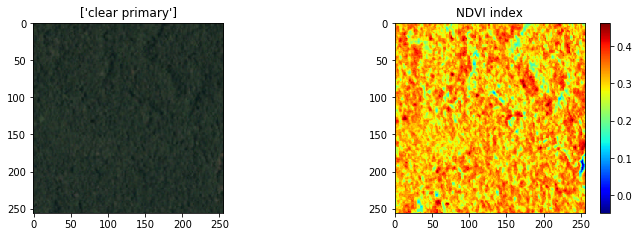

In [6]:
# Plot RGB image and NDVI
img_id = 0
plt.figure(figsize=(12,3.5))
plt.subplot(121)
plt.title(str(labels_df[labels_df.image_name == nine_image_names[img_id]].tags.values))
plt.imshow(plt.imread(nine_imgs_paths_jpg[img_id]))
plt.subplot(122)
plt.title('NDVI index')
plt.imshow(ndvis[img_id], cmap='jet')
plt.colorbar()
plt.show()

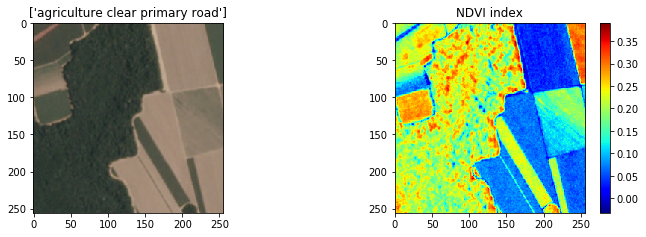

In [7]:
# Plot RGB image and NDVI
img_id = 4
plt.figure(figsize=(12,3.5))
plt.subplot(121)
plt.title(str(labels_df[labels_df.image_name == nine_image_names[img_id]].tags.values))
plt.imshow(plt.imread(nine_imgs_paths_jpg[img_id]))
plt.subplot(122)
plt.title('NDVI index')
plt.imshow(ndvis[img_id], cmap='jet')
plt.colorbar()
plt.show()

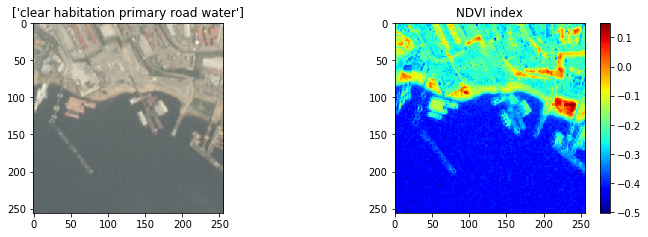

In [8]:
# Plot RGB image and NDVI
img_id = 6
plt.figure(figsize=(12,3.5))
plt.subplot(121)
plt.title(str(labels_df[labels_df.image_name == nine_image_names[img_id]].tags.values))
plt.imshow(plt.imread(nine_imgs_paths_jpg[img_id]))
plt.subplot(122)
plt.title('NDVI index')
plt.imshow(ndvis[img_id], cmap='jet')
plt.colorbar()
plt.show()

## Inspect labels

In [9]:
# Print shape
print(labels_df.shape)
# How does the training labels file look like?
labels_df.head()
#labels_df.tail()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Print all unique classes
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") 
                                        for tags in labels_df['tags'].values]))
num_labels = len(labels_list)
uniq_labels = set(labels_list) 
num_uniq_labels = len(uniq_labels) 
print("There are {} labels in the training set".format(num_labels))
print("distributed among {} classes:".format(num_uniq_labels))
print(uniq_labels)

There are 116278 labels in the training set
distributed among 17 classes:
{'road', 'slash_burn', 'partly_cloudy', 'habitation', 'water', 'bare_ground', 'cultivation', 'clear', 'primary', 'artisinal_mine', 'selective_logging', 'blow_down', 'conventional_mine', 'cloudy', 'agriculture', 'blooming', 'haze'}


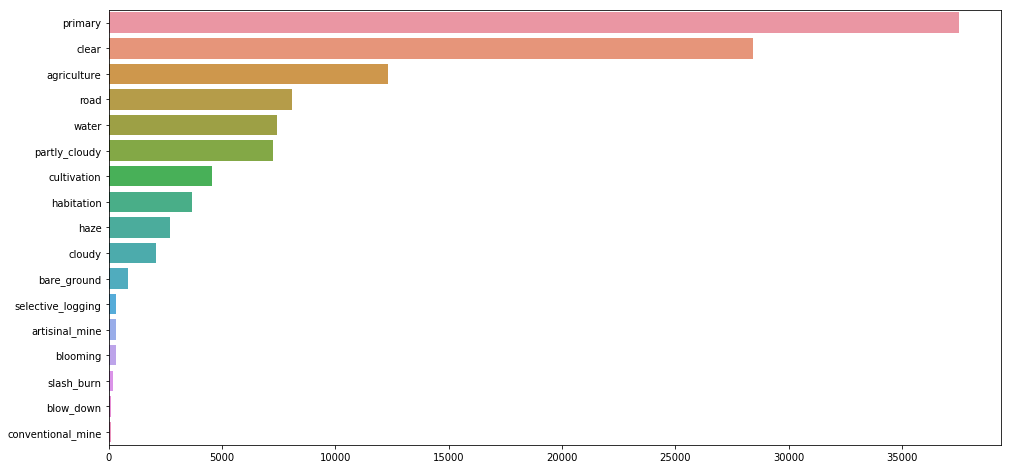

In [11]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')
plt.show()

## Image clustering
Use a t-SNE plot to identify clusters of images. More details on t-SNE [here](https://lvdmaaten.github.io/tsne/).

In [12]:
# Subset of images for clustering
n_imgs = 350
clust_imgs = []
image_paths = sorted(glob('../input/train-jpg/*.jpg'))[0:n_imgs]

# Image preprocessing
for i in range(n_imgs):
    img = plt.imread(image_paths[i])
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype('float')
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float')
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    clust_imgs.append(img)

# Convert into a Numpy array
img_mat = np.vstack(clust_imgs)
# Number of images, (100pix by 100pix) by 4 bands
img_mat.shape

(350, 40000)

In [13]:
# Fit a t-SNE manifold to the subset of images
tsne = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
).fit_transform(img_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 350 samples in 0.213s...
[t-SNE] Computed neighbors for 350 samples in 8.562s...
[t-SNE] Computed conditional probabilities for sample 350 / 350
[t-SNE] Mean sigma: 2.298054
[t-SNE] Computed conditional probabilities in 0.029s
[t-SNE] Iteration 50: error = 75.5006943, gradient norm = 0.4433669 (50 iterations in 0.131s)
[t-SNE] Iteration 100: error = 74.9476776, gradient norm = 0.4640604 (50 iterations in 0.124s)
[t-SNE] Iteration 150: error = 75.7937546, gradient norm = 0.4386446 (50 iterations in 0.128s)
[t-SNE] Iteration 200: error = 77.1723022, gradient norm = 0.4282276 (50 iterations in 0.129s)
[t-SNE] Iteration 250: error = 77.4910736, gradient norm = 0.4201789 (50 iterations in 0.123s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.491074
[t-SNE] Iteration 300: error = 0.9065586, gradient norm = 0.0066471 (50 iterations in 0.112s)
[t-SNE] Iteration 350: error = 0.7477767, gradient norm = 0.0011420 (

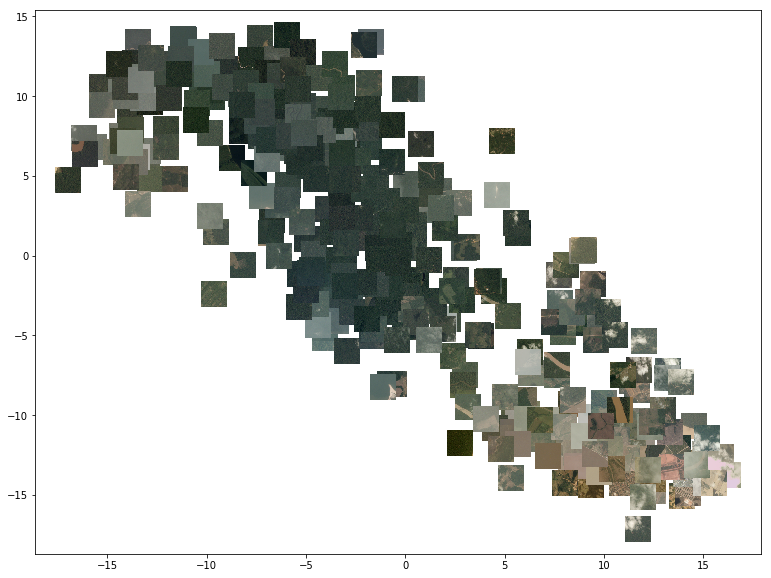

In [14]:
# Plot the subset of images in a two dimensional representation
def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

plt.figure(figsize=(13,10))
imscatter(tsne[0:n_imgs,0], tsne[0:n_imgs,1], [plt.imread(image_paths[i]) for i in range(n_imgs)])

## Basic image classification with Convolutional Neural Networks

### Using jpg images (RGB)

In [15]:
# Preprocess labels
x_train = []
x_test = []
y_train = []

df_train = pd.read_csv('../input/train_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [16]:
# Prepare array of images and vector representation of labels
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../input/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (32, 32)))
    y_train.append(targets)

100%|██████████| 40479/40479 [01:50<00:00, 364.86it/s]


In [17]:
# Maximum and minimum values in the array of training images
max_value = np.amax(x_train)
min_value = np.amin(x_train)

print('Min value in the training images array: ', min_value)
print('Max value in the training images array: ', max_value)

Min value in the training images array:  1
Max value in the training images array:  255


In [18]:
# Normalize images into the interval [0,1]
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.
print("Shape of the training images array is: ")
print(x_train.shape)
print("Shape of the training labels array is: ")
print(y_train.shape)

Shape of the training images array is: 
(40479, 32, 32, 3)
Shape of the training labels array is: 
(40479, 17)


In [19]:
# Split between training and validation sets
split = 35000 # Approx. 86% for training and 14% for validation
x_train, x_valid, y_train, y_valid = (x_train[:split], x_train[split:], 
                                      y_train[:split], y_train[split:])

In [20]:
# Create structure of Convolutional Neural Network
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              # We NEED binary here, since categorical_crossentropy 
              # l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
# Train model              
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_valid, y_valid))

Train on 35000 samples, validate on 5479 samples
Epoch 1/12
35000/35000 [==============================] - 11s 307us/step - loss: 0.2492 - acc: 0.9056 - val_loss: 0.1969 - val_acc: 0.9216
Epoch 2/12
35000/35000 [==============================] - 6s 168us/step - loss: 0.2006 - acc: 0.9209 - val_loss: 0.1831 - val_acc: 0.9260
Epoch 3/12
35000/35000 [==============================] - 6s 168us/step - loss: 0.1879 - acc: 0.9260 - val_loss: 0.1725 - val_acc: 0.9312
Epoch 4/12
35000/35000 [==============================] - 6s 169us/step - loss: 0.1797 - acc: 0.9297 - val_loss: 0.1651 - val_acc: 0.9347
Epoch 5/12
35000/35000 [==============================] - 6s 168us/step - loss: 0.1738 - acc: 0.9318 - val_loss: 0.1633 - val_acc: 0.9354
Epoch 6/12
35000/35000 [==============================] - 6s 168us/step - loss: 0.1690 - acc: 0.9339 - val_loss: 0.1562 - val_acc: 0.9388
Epoch 7/12
35000/35000 [==============================] - 6s 169us/step - loss: 0.1659 - acc: 0.9351 - val_loss: 0.1575 - 

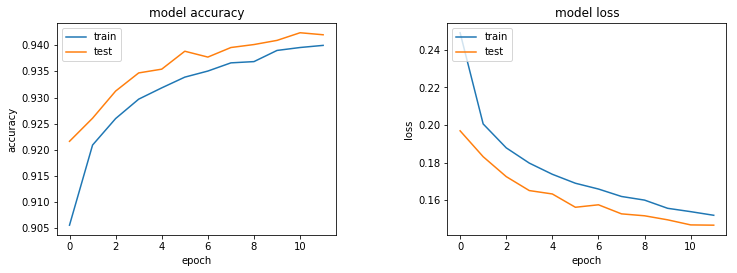

In [22]:
# Plot model accuracy and loss

fig, axs = plt.subplots(1, 2, figsize=(12, 3), sharey=False)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Use the model to predict
p_valid = model.predict(x_valid, batch_size=128)

#np.set_printoptions(precision=2)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print("## For a sample of 3 images and the first 5 labels (of 17)\n")
print("True vectorized labels")
print(np.round(y_valid[0:3,0:7]/1.0,2))
print("-------------------------------------------------------")
print("Predicted vectorized labels")
print(np.round(p_valid[0:3,0:7],2))

## For a sample of 3 images and the first 5 labels (of 17)

True vectorized labels
[[ 0.000  1.000  0.000  0.000  0.000  0.000  1.000]
 [ 1.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  1.000]]
-------------------------------------------------------
Predicted vectorized labels
[[ 0.390  0.010  0.020  0.140  0.220  0.020  0.270]
 [ 0.360  0.010  0.380  0.180  0.270  0.020  0.300]
 [ 0.270  0.010  0.600  0.150  0.450  0.030  0.270]]


In [24]:
# Print validation accuracy
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

0.8642724960831619
